In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm as lgb
import plotly.express as px

In [3]:
def load_data(path):
    df = pd.read_csv(path)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df.columns = ['customerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'Tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
    df = df.drop(columns = ['customerID'])
    cat_cols = df.select_dtypes('object').columns.to_list()
    for col in cat_cols:
        df[col] = df[col].str.title()
    df = df.dropna()
    return df

In [4]:
df = load_data('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
for col in df.columns:
    print(col, df[col].unique())

Gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
Tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService ['No' 'Yes']
MultipleLines ['No Phone Service' 'No' 'Yes']
InternetService ['Dsl' 'Fiber Optic' 'No']
OnlineSecurity ['No' 'Yes' 'No Internet Service']
OnlineBackup ['Yes' 'No' 'No Internet Service']
DeviceProtection ['No' 'Yes' 'No Internet Service']
TechSupport ['No' 'Yes' 'No Internet Service']
StreamingTV ['No' 'Yes' 'No Internet Service']
StreamingMovies ['No' 'Yes' 'No Internet Service']
Contract ['Month-To-Month' 'One Year' 'Two Year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic Check' 'Mailed Check' 'Bank Transfer (Automatic)'
 'Credit Card (Automatic)']
MonthlyCharges [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges [  29.85 1889.5   

In [6]:
df.shape

(7032, 20)

In [7]:
df[df['Contract'] != 'Month-To-Month'].shape

(3157, 20)

In [8]:
df[df['Contract'] == 'Two Year'].shape

(1685, 20)

In [9]:
from feature_engine.encoding import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [10]:
ohe = OneHotEncoder(drop_last=True)
scaler = StandardScaler()


In [15]:
def create_sub_df(dataframe, colname, col_type_name):
    tmp = dataframe[dataframe[colname] == col_type_name]
    tmp = tmp.drop(columns=[colname, 'TotalCharges', 'Tenure']).reset_index(drop=True)
    tmp.SeniorCitizen.replace({0: "No", 1: "Yes"}, inplace=True)
    return tmp

In [16]:
def make_X_Y(dataframe, target):
    X = dataframe.drop(columns=[target])
    y = dataframe[target]
    return X, y

def make_cat_num_cols(dataframe ):
    cat_cols = dataframe.select_dtypes('object').columns 
    num_cols = [c for c in dataframe.columns if not c in cat_cols]
    return cat_cols, num_cols

def transform_cat_cols(dataframe, cols_list, encoder=None):
    cat_data = encoder.fit_transform(dataframe[cols_list])
    return cat_data

def transform_num_cols(dataframe, cols_list, encoder=None):
    num_data = encoder.fit_transform(dataframe[cols_list])
    num_data = pd.DataFrame(num_data, columns=cols_list)
    return num_data


In [17]:
df.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [18]:
df['Contract'].unique()

array(['Month-To-Month', 'One Year', 'Two Year'], dtype=object)

In [123]:
month_df = create_sub_df(df, 'Contract', 'Month-To-Month')
X, y = make_X_Y(month_df, 'Churn')
cat_cols, num_cols = make_cat_num_cols(X)
cat_data = transform_cat_cols(X, cat_cols, encoder=ohe)
num_data= transform_num_cols(X, num_cols, encoder=scaler)

In [124]:
whole_data = pd.concat([cat_data, num_data], axis=1)
X_train, X_val, y_train, y_val = train_test_split(whole_data, y, test_size=0.2, random_state=2024,stratify=y)

In [127]:
def train_model(X_train,X_val, y_train, y_val , model):

    model.fit(X_train, y_train)
    preds= model.predict(X_val)
    preds_proba = model.predict_proba(X_val)[:,1]

    return preds, preds_proba
                    

In [128]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=500, random_state=2024)

preds, preds_proba = train_model(X_train,X_val, y_train, y_val , model=log_reg)

In [130]:
imp_df = pd.DataFrame(log_reg.coef_[0], index=X_train.columns, columns=['Score'])
imp_df.sort_values(by='Score',ascending=False, inplace=True)
fig = px.bar(imp_df.head(20), x = 'Score')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
# st.plotly_chart(fig)
fig.show()

In [133]:
preds_proba[preds_proba > 0.4] =1
preds_proba[preds_proba <= 0.4] =0

In [136]:
preds_proba = pd.Series(preds_proba).map({1: "Yes", 0:"No"})

In [137]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

          No       0.74      0.60      0.66       444
         Yes       0.57      0.72      0.64       331

    accuracy                           0.65       775
   macro avg       0.66      0.66      0.65       775
weighted avg       0.67      0.65      0.65       775



In [138]:
print(classification_report(y_val, preds_proba))

              precision    recall  f1-score   support

          No       0.81      0.47      0.60       444
         Yes       0.55      0.85      0.67       331

    accuracy                           0.63       775
   macro avg       0.68      0.66      0.63       775
weighted avg       0.70      0.63      0.63       775



In [98]:
X_val['predictions'] = preds_proba[preds_proba]
X_val['Actual'] = y_val.values

In [103]:
X_val[(X_val['Actual'] == "Yes") & (X_val['predictions'] < 0.5 )]

,Gender_Female,SeniorCitizen_No,Partner_Yes,Dependents_No,PhoneService_No,MultipleLines_No Phone Service,MultipleLines_No,InternetService_Dsl,InternetService_Fiber Optic,OnlineSecurity_No,...,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,PaperlessBilling_Yes,PaymentMethod_Electronic Check,PaymentMethod_Mailed Check,PaymentMethod_Credit Card (Automatic),MonthlyCharges,predictions,Actual
2053,0,1,0,1,0,0,0,0,1,1,...,0,0,1,1,0,0,1,0.841340,0.470104,Yes
1026,1,1,0,1,0,0,1,1,0,1,...,0,1,0,0,0,1,0,-0.759514,0.435696,Yes
241,0,1,0,1,0,0,1,1,0,1,...,0,1,0,1,0,0,0,-0.779943,0.421185,Yes
2516,1,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,-0.588657,0.449753,Yes
696,0,1,0,1,0,0,1,1,0,1,...,0,1,0,0,0,1,0,-0.792943,0.419964,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,-1.740084,0.245751,Yes
1543,1,1,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0.501484,0.058228,Yes
390,1,1,0,1,0,0,1,0,1,0,...,0,1,0,1,0,0,0,0.499627,0.389347,Yes
3643,0,1,0,1,0,0,0,1,0,1,...,0,0,1,0,0,0,0,-0.161515,0.332776,Yes


,No,Yes,accuracy,macro avg,weighted avg
precision,0.728291,0.559809,0.637419,0.644050,0.656333
recall,0.585586,0.706949,0.637419,0.646267,0.637419
f1-score,0.649189,0.624833,0.637419,0.637011,0.638786
support,444.000000,331.000000,0.637419,775.000000,775.000000


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

In [140]:
import plotly.express as px
x = ['No Churn', "Churn"]
y = ['No Churn', "Churn"]
px.imshow(confusion_matrix(y_val, preds_proba),x=x, y=y,color_continuous_scale='tropic',text_auto=True)

Text(0.5, 1.0, 'CONFUSION MATRIX')

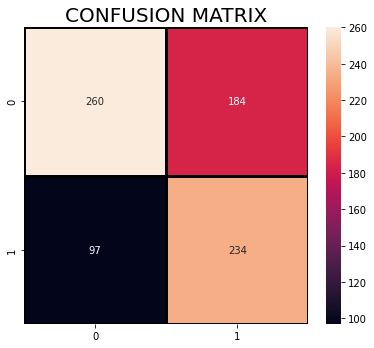

In [41]:
plt.figure(figsize=(14,12))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_val, preds),
            annot=True,fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

In [47]:
y_val.value_counts()

No     444
Yes    331
Name: Churn, dtype: int64

In [43]:
from sklearn.metrics import accuracy_score
print ("\naccuracy_score :",accuracy_score(y_val, preds))


accuracy_score : 0.6374193548387097


In [45]:
print ("\nclassification report :\n",(classification_report(y_val, preds)))


classification report :
               precision    recall  f1-score   support

          No       0.73      0.59      0.65       444
         Yes       0.56      0.71      0.62       331

    accuracy                           0.64       775
   macro avg       0.64      0.65      0.64       775
weighted avg       0.66      0.64      0.64       775

